### Ecology Domain CRIs



This document is intended to accompany the publication "Critical Risk Indicators (CRIs) for the electric power grid: Asurvey and discussion of interconnected effects".


The R script contains two parts:
1. Calculating ecology CRIs using bird abundance data (population size estimates based on Breeding Bird Survey data)
2. Estimating abundance metrics from occurrence data (eBird) as another source of data for calculating CRIs

First we will read in the ecology datasets, available in our "data" folder on bitbucket


In [1]:
## load required libraries

library(tidyverse)

library(sf)
library(lubridate)
library(dggridR)
library(ranger)
library(scam)
library(PresenceAbsence)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0


Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date


Loading required package: rgdal

Loading required package: sp

rgdal: version: 1.5-12, (SVN revision 1018)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.4.2, released 2019/06/28
Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/gdal
GDAL binary built with GEOS: FALSE 
Loaded PROJ runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
Path to PROJ shared files: 

We first calculate ecology CRIs using bird abundance data. The indices are: geometric mean abundance, Shannon diversity index, and Simpson's diversity index. 

We read in the dataset, which are Breeding Bird Survey (BBS) data from 1993-2017 for the entire survey region. Annual data by state or by Bird Conservation Region (BCR) are also available.




In [2]:

## Read in datasets

# BBS dataset: survey-wide indices by year for each species
surveyDat <- read.csv("BBSsurveyDat.csv", sep=",", header=T, stringsAsFactors = F) 


# Population estimates to use as weights for calculating annual population sizes, from Rosenberg et al. 2019
  # Rosenberg KV, Dokter AM, Blancher PJ, et al. Decline of the North American avifauna. Science. 2019; 366(6461):120-124.
popest <- read.csv("rosenberg_popest.csv", sep=",", header=T, stringsAsFactors = F) 



We then convert BBS index data to annual population size estimates (the number of birds per year), following methods presented in Rosenberg et al. 2019. We calculate these estimates based on scaled indices (scaled to year 1970) and scaled and logged indices. 


In [6]:
# first re-scale indices to a common base-year (1970) and log-transform
dat1 <- surveyDat %>%
  filter(Common.Name %in% popest$species) %>%  
  group_by(Scientific.Name) %>%
  mutate(indstd = (Index)/(first(Index))) %>%   
  mutate(indstdln = log(indstd)) 


## calculate scaling factor based on population size estimate
  # for each species, pull out the relevant years based on first and last years in popest file
  # divide popest by indstd from that year
## popest represents the species’ mean population size between first and last years
  # sum across years and divide by number of years
  # multiply each indstdln by this scaling factor

dat1$yrpopest <- dat1$yrpopestln <- rep(NA, nrow(dat1))

species <- unique(dat1$Common.Name )[order(unique(dat1$Common.Name ), decreasing = FALSE)]

scale <- c()


for (j in 1: length(species)) {
  
  popsub <- popest[which(popest$species == species[j]), ]
  
  datsub <- dat1  %>%
    
    filter(Common.Name == species[j] & Year >= popsub$first_year_popest & Year <= popsub$last_year_popest )  
  
  timelength <- popsub$last_year_popest - popsub$first_year_popest + 1
  
  scale[j] <- sum( popsub$popest / datsub$indstd ) / timelength
  
  dat1$yrpopest[which(dat1$Common.Name == species[j])] <- dat1$indstd[which(dat1$Common.Name == species[j])] * scale[j]
  
  dat1$yrpopestln[which(dat1$Common.Name == species[j])] <- dat1$indstdln[which(dat1$Common.Name == species[j])] * scale[j]
  
}



## for a few species, the popest are from years outside of 1993-2017, creating abundance estimates of 0
  # filter these out
dat2 <- dat1 %>%
  filter(yrpopest != 0)



In [7]:
#-----------------------------------------------
## calculate CRIs over time based on estimated abundances

  #### Geometric mean abundance across species 
  #### Simpson's Diversity index (D) = 1/sum(proportion of each species^2); Higher = more diverse
    #### Sensitive to abundance of more abundant species; poor indicator of richness
  #### Shannon-Weiner Diversity index (S) = -sum(proportion of each species*log(proportion of each species)); Higher = more diverse
    #### Sensitive to abundance of rarer species, more sensitive to evenness
#-----------------------------------------------

dat3 <- summarise(group_by(dat2, Year), 
                  geometricMean = exp(mean(log(yrpopest))),
                  Simpson = 1/sum((yrpopest/(sum(yrpopest)))^2),
                  Shannon = -sum((yrpopest/(sum(yrpopest))) * log(yrpopest/(sum(yrpopest))) )
) %>% 
  gather(CRIs, value, geometricMean:Shannon)     ## stack quantile values into 1 column for plotting



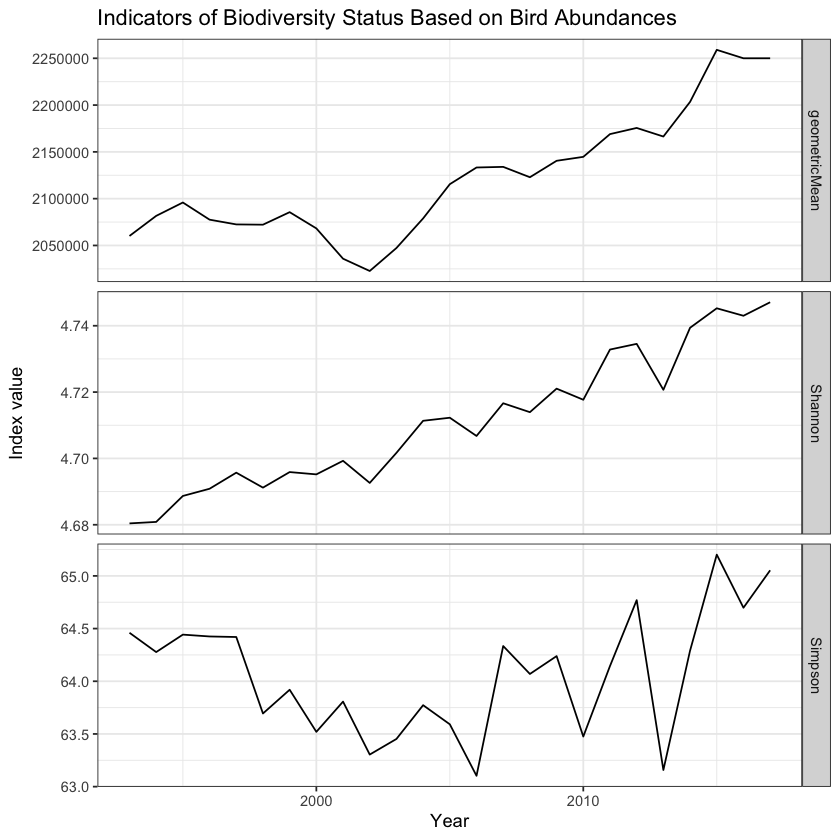

In [8]:
## plot 
ggplot(data = dat3, aes(x=Year, y=value)) +
  geom_line() +
  labs(title = "Indicators of Biodiversity Status Based on Bird Abundances",
        x = "Year", y = "Index value") +
  facet_grid(CRIs ~ ., scales='free') +
  theme_bw()


Second, we estimate a metric of abundance using species occurrence data, which has finer spatial and temporal resolutions and may be more versatile for aligning with data from other domains. The metric of abundance we calculate here is encounter rate by month and town, and the data source is eBird. We focus on the state of Massachusetts, the years 2005-2018, and the species Red-bellied Woodpecker as an example. 

Encounter rates are estimated using a random forest model to account for observer effort following recommended methods for eBird data (Strimas-Mackey et al. 2020). The data are first filtered and cleaned to produce the appropriate detection/non-detection data needed for analysis. Then the analysis is conducted on a subsample of the data to reduce spatial and temporal bias. 


Reading layer `MA_Towns_Shape_Final' from data source `/Users/jchecastaldo/OneDrive - Lincoln Park Zoo/IdeasLab2019/datasets/analysis/Ecology_jupyterNB/MA_Towns_Shape_Final.shp' using driver `ESRI Shapefile'
Simple feature collection with 352 features and 24 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -73.50821 ymin: 41.19874 xmax: -69.92356 ymax: 42.88678
CRS:            4326
Resolution: 13, Area (km^2): 31.9926151554038, Spacing (km): 5.58632116604266, CLS (km): 6.38233997895802


[1] 399312

species_observed,n,percent
<lgl>,<int>,<dbl>
FALSE,298864,0.7484473
TRUE,100448,0.2515527


[1] 132112

species_observed,n,percent
<lgl>,<int>,<dbl>
FALSE,87867,0.6650948
TRUE,44245,0.3349052


test  train 
 26330 105779



|model         |   mse| sensitivity| specificity|   auc| kappa|
|:-------------|-----:|-----------:|-----------:|-----:|-----:|
|RF            | 0.183|       0.654|       0.756| 0.783| 0.395|
|Calibrated RF | 0.173|       0.650|       0.760| 0.783| 0.396|

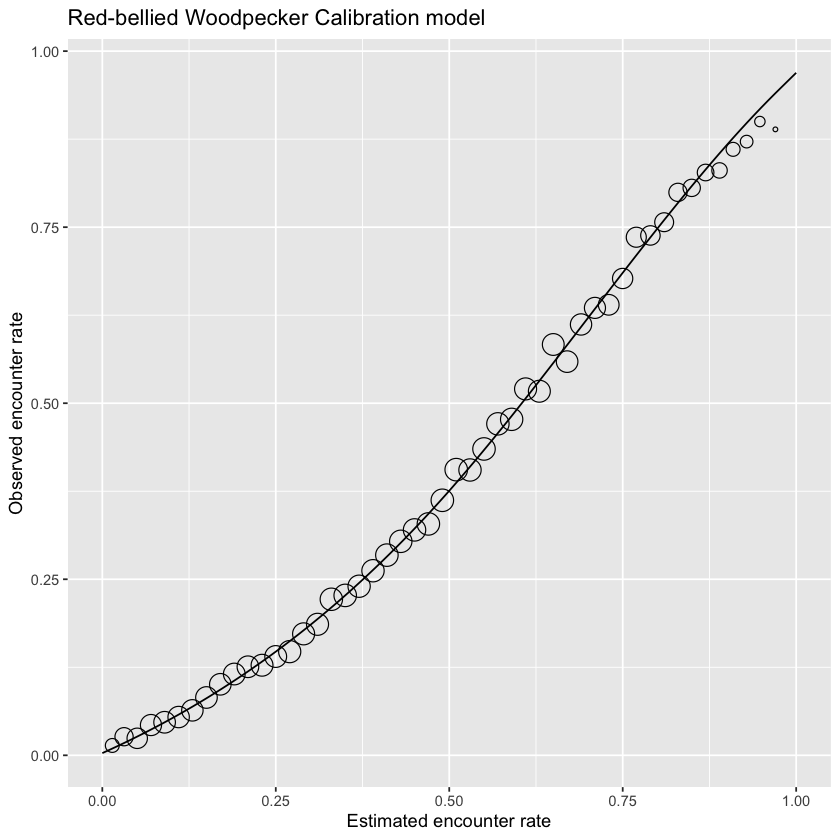

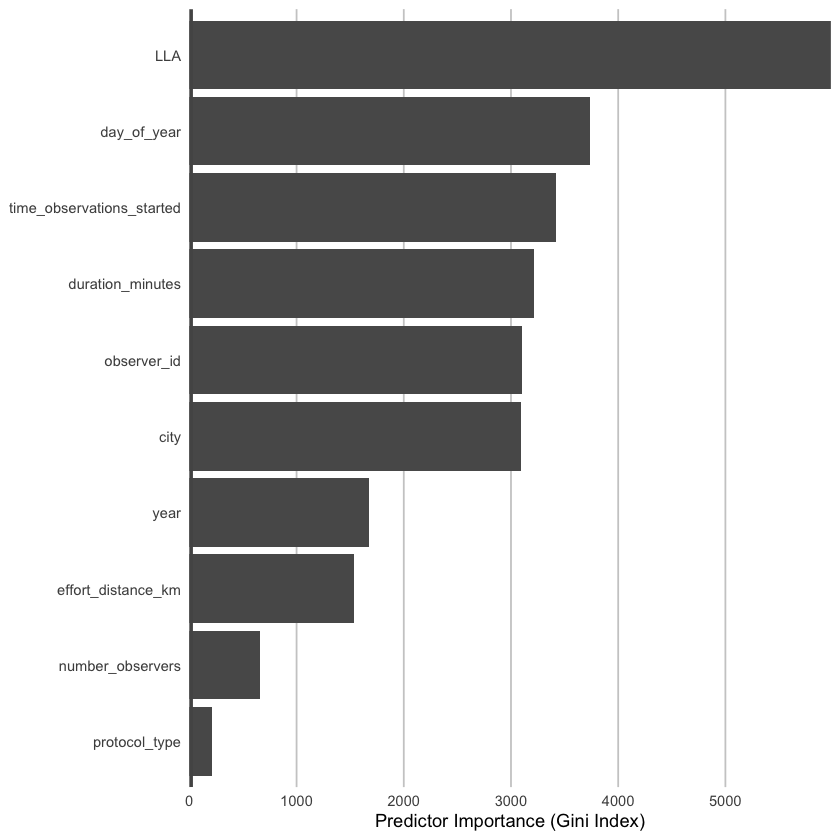

[1] 5.092199

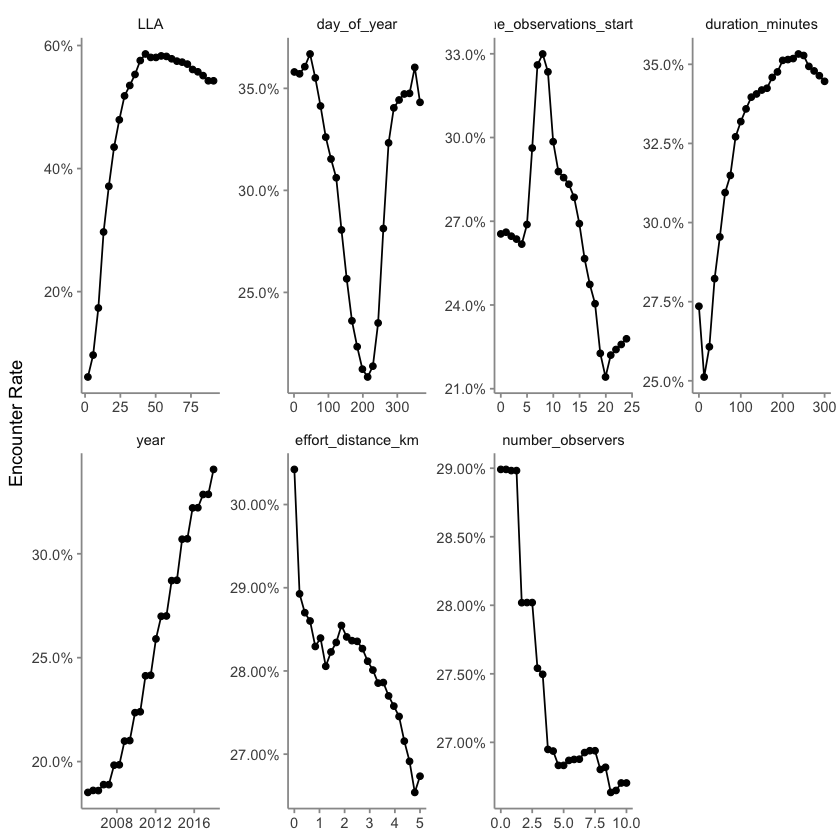

In [9]:
# Start with downloaded, filtered, and cleaned data from the raw eBird data (EBD) 
  # Download both the world EBD (observational data) and corresponding sampling event data (checklist data)
# An overview of the filtering and cleaning process to produce the final detection/non-detection data is included below

# The filtering, data exploration, and encounter rate modeling procedures are referenced from Strimas-Mackey et al. 2020.
  # Strimas-Mackey, M., W.M. Hochachka, V. Ruiz-Gutierrez, O.J. Robinson, E.T. Miller, T. Auer, S. Kelling, D. Fink, A. Johnston. 2020. 
  # Best Practices for Using eBird Data. Version 1.0. https://cornelllabofornithology.github.io/ebird-best-practices/. 

#-------------------------------
# DATA EXTRACTION AND FILTERING
#-------------------------------
# It's important to filter the sampling event and observation data together so that the same filters are applied:

# 1. Define filters
#     May 1-July 15 is defined as appropriate dates for BBS surveying. 
#     We include stationary, traveling, and random protocols that had survey durations up to 5 hours and traveled distances up to 5km. 
#     Species were filtered to Red-bellied woodpecker observations.
#     Only complete checklists (All observed species were reported) were included. This removed the possiblility of a non-detection
#     actually being a species that went unreported (observer taxa preference).

# 2. Run filtering on EBD raw data

# In addition, apply the above filters to the raw data again, but include ALL species (remove the auk_species() filter)
# This is used to generate List Lengths (number of species reported by each checklist/survey, a proxy for observer effort/skill) for each checklist.


#--------------------------------------------------
# ADDITONAL DATA FILTERING AND PREPARATION FUNCTIONS
#--------------------------------------------------

# Zero-fill observation data to create detection/non-detection data using auk_zerofill() from R package auk.
# auk_zerofill automatically applies auk_rollup() which rolls up sub-species observations to species level (drops hybids and family level observations)
# and auk_unique() which gets rid of duplicate checklists that are part of a group suvery and keeps one idependent copy.
# using collapse = TRUE condenses the observation data and checklist data into one dataframe. 

# Clean up variables. Convert individual counts of species with 'X' to NA, change survey distances to 0 km for non-traveling/stationary
# counts, convert time to decimal hours since midnight, and split date into year,month, and day of year.
# Also reclassify "random" protocol as either stationary or traveling depending on the distance traveled, and add List Length Analysis (LLA) variable.

# Additional filtering suggested by Strimas-Mackey et al. 2020 to further reduce variation in detectability between checklists:
# Filter for durations less than 5hr long, 5km in length, and 10 or fewer observers.
# Remove checklists with only 1 species reported (likely a false reporting of completeness or a targeted search).

# The raw ebird data is now cleaned and filtered to the desired parameters



#-----------------------------------------------
# Read in datasets
#-----------------------------------------------
# Read in species detections
ebird <- read.csv("redbellied_detections.csv")
ebird$observation_date <- ymd(ebird$observation_date)


# Read in Massachusetts towns data
crs <- st_crs(4326)
towns <- st_read("MA_Towns_Shape_Final.shp") %>% 
  select(city, TOWN_ID,) %>%
  st_transform(crs = crs)



# set random number seed to insure fully repeatable results
set.seed(1)


#-----------------------------------------------
# SPATIOTEMPORAL SUBSAMPLING
  # Reduce spatial and temporal bias as well as class imbalance (detection to non-detection ratio)
  # Sample one detection and one non-detection checklist from each grid cell for each month
#-----------------------------------------------

# generate hexagonal grid with ~ 5 km betweeen cells
dggs <- dgconstruct(spacing = 5)

# get hexagonal cell id and month number for each checklist
checklist_cell <- ebird %>% 
  mutate(cell = dgGEO_to_SEQNUM(dggs, longitude, latitude)$seqnum,
         year = year(observation_date),
         month = month(observation_date),
         week = week(observation_date))

# sample one checklist per grid cell per month 
# sample detection/non-detection independently 
ebird_ss <- checklist_cell %>% 
  group_by(species_observed, year, week, cell) %>% 
  sample_n(size = 1) %>% 
  ungroup()


## CHECK: How did this effect prevalence of detections to non detections? 

# original data
nrow(ebird)  # 399,183 redbellied checklists

# ~25% detection rate in original data
count(ebird, species_observed) %>% 
  mutate(percent = n / sum(n))


# after sampling
nrow(ebird_ss)  # 132,075 redbellied checklists

# ~33% detection rate after subsampling data
count(ebird_ss, species_observed) %>% 
  mutate(percent = n / sum(n))

# NOTE: detection prevalence increased with subsampling which will increase the occurrence rate of the model predictions


#------------------------------
# RANDOM FOREST PREDICTIONS
#------------------------------

# split data into testing and training data; 80/20

ebird_split <- ebird_ss %>% 
  # select only the columns (variables) to be used in the model
  select(species_observed,
         year, day_of_year,
         time_observations_started, duration_minutes,
         effort_distance_km, number_observers, 
         protocol_type,
         LLA,
         city,observer_id) %>% 
  drop_na()

set.seed(1)

 
ebird_split <- ebird_split %>% 
  split(if_else(runif(nrow(.)) <= 0.8, "train", "test"))
map_int(ebird_split, nrow)


# Since we have class imbalance (greater non-detections than detections) we will use a balanced random forests approach.
# It samples an equal proportion of detections and non detections in each random sample.

# To use this approach we need to calculate the proportion of detections in the dataset:
detection_freq <- mean(ebird_split$train$species_observed)

# ranger requires a factor response to do classification
ebird_split$train$species_observed <- factor(ebird_split$train$species_observed)

# grow random forest, sample.fraction parameter addresses the balanced sampling, tells model to sample equal detections/nondetections
# probabilies=TRUE returns the probabilities rather than just returning the most probable class (1 or 0)
rf <- ranger(formula =  species_observed ~ ., 
             data = ebird_split$train,
             importance = "impurity",
             probability = TRUE,
             replace = TRUE, 
             sample.fraction = c(detection_freq, detection_freq))

# Probabilies don't always align with detection frequency, especially since we resampled and increased the detection ratio.
# Producing a calibration of the predictions can help better diagnose the predictions and realign the predictions with observations.
# To calibrate, predict encounter rate for each checklist in training data and then fit binomial GAM with real observed encounter
# rate as the response and predicted encounter rate as the predictor variable. 
# Use GAM constrained to only increase since we a priori expect encounter rate to increase with predicted encounter rate. Use scam() to do this.

# make predictions on training data (we want probabilites of detection which is the second column in predictions)
occ_pred <- rf$predictions[, 2]

# convert the observed response back to a numeric value from factor
occ_obs <- ebird_split$train$species_observed %>% 
  as.logical() %>% 
  as.integer()

rf_pred_train <- tibble(obs = occ_obs, pred = occ_pred) %>% 
  drop_na()

# fit calibration model
calibration_model <- scam(obs ~ s(pred, k = 5, bs = "mpi"), 
                          gamma = 1.4,
                          data = rf_pred_train)

# calculate the average observed encounter rates for different categories of estimated encounter rates 
average_encounter <- rf_pred_train %>%
  mutate(pred_cat = cut(rf_pred_train$pred, breaks = seq(0, 1, by=0.02))) %>%
  group_by(pred_cat) %>%
  summarise(pred = mean(pred), obs = mean(obs), checklist_count = n()) %>%
  ungroup()

# plot calibration results
cal_pred <- tibble(pred = seq(0, 1, length.out = 100))
cal_pred <- predict(calibration_model, cal_pred, type = "response") %>% 
  bind_cols(cal_pred, calibrated = .)

ggplot(cal_pred) +
  aes(x = pred, y = calibrated) +
  geom_line() +
  geom_point(data = average_encounter, 
             aes(x = pred, y = obs, size = sqrt(checklist_count)),
             show.legend = FALSE, shape = 1) +
  labs(x = "Estimated encounter rate",
       y = "Observed encounter rate",
       title = "Red-bellied Woodpecker Calibration model")

# Estimated encounter rates are fairly balanced with observed encounter rates. Sites with higher estimations have higher
# observed encounters. Model is good at estimating accurately and can distinguish sites with low rates from high rates.

# If accurate encounter rates are required, calibration model can be used to calibrate the estimates from the RF model, so they 
# are adjusted to match the observations more closely. Calibrated RF model is combination of the original RF followed by the calibration model.



#------------------------------
# MODEL ASSESSMENT
  # Assess the quality of both uncalibrated and calibrated models in predicting observed patterns of occupancy using validation data from the 20% test data set.
  # Predictive performance metrics to compare the predictions to the actual observations (require binary thresholds for probabilites): 
  # mean squared error (MSE), sensitivity, specificity, AUC, and Kappa.
#------------------------------

# predict on test data using calibrated model
p_fitted <- predict(rf, data = ebird_split$test, type = "response")

# extract probability of detection
p_fitted <- p_fitted$predictions[, 2]

# calibrate
p_calibrated <- predict(calibration_model, 
                        newdata = tibble(pred = p_fitted), 
                        type = "response")
rf_pred_test <- data.frame(id = seq_along(p_calibrated),
                           # actual detection/non-detection
                           obs = ebird_split$test$species_observed,
                           # uncalibrated prediction
                           fit = p_fitted,
                           # calibrated prediction
                           cal = p_calibrated) %>%
  # constrain probabilities to 0-1
  mutate(cal = pmin(pmax(cal, 0), 1)) %>% 
  drop_na()

# mean squared error (mse)
mse_fit <- mean((rf_pred_test$obs - rf_pred_test$fit)^2, na.rm = TRUE)
mse_cal <- mean((rf_pred_test$obs - rf_pred_test$cal)^2, na.rm = TRUE)

# pick threshold to maximize kappa
opt_thresh <- optimal.thresholds(rf_pred_test, opt.methods = "MaxKappa")

# calculate accuracy metrics: auc, kappa, sensitivity, specificity,
metrics_fit <- rf_pred_test %>% 
  select(id, obs, fit) %>% 
  presence.absence.accuracy(threshold = opt_thresh$fit, 
                            na.rm = TRUE, 
                            st.dev = FALSE)

metrics_cal <- rf_pred_test %>% 
  select(id, obs, cal) %>% 
  presence.absence.accuracy(threshold = opt_thresh$cal, 
                            na.rm = TRUE, 
                            st.dev = FALSE)

rf_assessment <- tibble(
  model = c("RF", "Calibrated RF"),
  mse = c(mse_fit, mse_cal),
  sensitivity = c(metrics_fit$sensitivity, metrics_cal$sensitivity),
  specificity = c(metrics_fit$specificity, metrics_cal$specificity),
  auc = c(metrics_fit$AUC, metrics_cal$AUC),
  kappa = c(metrics_fit$Kappa, metrics_cal$Kappa)
)

knitr::kable(rf_assessment, digits = 3)

# If objective is to ensure model includes all areas of species presence (over truth of those presences), we want high sensitivity.
# The RF model performes slightly better in this regard.



#------------------------------
# PREDICTOR IMPORTANCE
#------------------------------

pi <- enframe(rf$variable.importance, "predictor", "importance")

# plot
ggplot(pi) + 
  aes(x = fct_reorder(predictor, importance), y = importance) +
  geom_col() +
  geom_hline(yintercept = 0, size = 2, colour = "#555555") +
  scale_y_continuous(expand = c(0, 0)) +
  coord_flip() +
  labs(x = NULL, 
       y = "Predictor Importance (Gini Index)") +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        panel.grid.major.x = element_line(colour = "#cccccc", size = 0.5))

#LLA (List Length), day of year, time of day, and survey duration are important predictors


# top 8 predictors, filter out factor predictors (cannot calculate partial dependence for those)
top_pred <- pi %>% 
  filter(!predictor %in% c("city", "observer_id", "protocol_type")) %>%
  #top_n(n = 8, wt = importance) %>% 
  arrange(desc(importance))


# Create partial dependence function to calculate partial dependence for the top predictors
# Takes the following arguements:
# 1. predictor: name of predictor to calculate partial dependence for
# 2. model: the encounter rate model
# 3. data: the original data used to train the model
# 4. x_res: the resolution of the grid over which to calculate partial dependence
# 5. n: number of points to subsample from the training data

# function to calculate partial dependence for a single predictor
calculate_pd <- function(predictor, model, data, 
                         x_res = 25, n = 1000) {
  
  # create prediction grid
  rng <- range(data[[predictor]], na.rm = TRUE)
  x_grid <- seq(rng[1], rng[2], length.out = x_res)
  grid <- data.frame(covariate = predictor, x = x_grid, 
                     stringsAsFactors = FALSE)
  names(grid) <- c("covariate", predictor)
  
  # subsample training data
  n <- min(n, nrow(data))
  s <- sample(seq.int(nrow(data)), size = n, replace = FALSE)
  data <- data[s, ]
  
  # drop focal predictor from data
  data <- data[names(data) != predictor]
  grid <- merge(grid, data, all = TRUE)
  
  # predict
  p <- predict(model, data = grid)
  
  # summarize
  pd <- grid[, c("covariate", predictor)]
  names(pd) <- c("covariate", "x")
  pd$pred <- p$predictions[, 2]
  pd <- dplyr::group_by(pd, covariate, x) %>% 
    dplyr::summarise(pred = mean(pred, na.rm = TRUE)) %>% 
    dplyr::ungroup()
  
  return(pd)
}


# calculate partial dependence for each predictor
# map is used to iteratively apply calculate_pd to each predictor
pd <- top_pred %>% 
  mutate(pd = map(predictor, calculate_pd, model = rf, 
                  data = ebird_split$train),
         pd = map(pd, ~ .[, c(2, 3)]),
         pd = map(pd, set_names, nm = c("value",  "encounter_rate"))) %>% 
  unnest(cols = pd)

# calibrate predictions
pd$encounter_rate <- predict(calibration_model, 
                             newdata = tibble(pred = pd$encounter_rate), 
                             type = "response") %>% 
  as.numeric()

# Partial dependence plots show the marginal effect of a given predictor on encounter rate averaged across the other predictors. 
ggplot(pd) +
  aes(x = value, y = encounter_rate) +
  geom_line() +
  geom_point() +
  scale_y_continuous(labels = scales::percent) +
  facet_wrap(~ as_factor(predictor), nrow = 2, scales = "free") +
  labs(x = NULL, y = "Encounter Rate") +
  theme_minimal() +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.line = element_line(color = "grey60"),
        axis.ticks  = element_line(color = "grey60"))

# For red-bellied woodpecker, encounter rate increases with List Length and survey duration but levels off at a certain point.
# Rates increase steadily with year which may reflect the increase in data availability over the years.
# Survey distance and number of observers actually decreases the overall encounter rate.


#------------------------------
# CREATE SPATIAL PREDICTION SURFACE (use towns as spatial preditors)
  # For prediction data, use peak time of day, peak day of each month, and a standard checklist traveling 1km for 1hr. 
  # Make predictions for all months of all years (2005-2018).
#------------------------------

# find peak time of day from partial dependence
pd_time <- calculate_pd("time_observations_started",
                        model = rf, 
                        data = ebird_split$train,
                        # make estimates at 30 minute intervals using a subset of the training dataset
                        x_res = 2 * 24, n = 1000) %>% 
  transmute(time_observations_started = x, encounter_rate = pred)

# hours with at least 1% of checklists
search_hours <- ebird_split$train %>% 
  mutate(hour = floor(time_observations_started)) %>%
  count(hour) %>% 
  mutate(pct = n / sum(n)) %>% 
  filter(pct >= 0.01)

# constrained peak time
t_peak <- pd_time %>% 
  filter(floor(time_observations_started) %in% search_hours$hour) %>% 
  top_n(1, wt = desc(time_observations_started)) %>% 
  pull(time_observations_started)
t_peak
# 5.09, Peak time of day is 5 am for redbellied woodpecker


# Find peak day of year within each month using occurrence frequency
# add month to dataset based on day of year
ebird_split$train$month <- as.numeric(format(strptime(paste(ebird_split$train$day_of_year), format = "%j"), '%m'))

occur_dom <- function(data) {data %>% 
    group_by(month, day_of_year) %>%
    summarise(n_checklists = n(),
              n_detected = sum(as.integer(species_observed)),
              det_freq = mean(as.integer(species_observed)))
  }
  
peak_dom <- occur_dom(ebird_split$train) %>%
  group_by(month) %>%
  filter(det_freq == max(det_freq))
peak_dom <- peak_dom[!duplicated(peak_dom$month),]


# add effort covariates to town prediction surface
pred_town_eff <- towns %>% 
  mutate(year = rep(c(2005:2018), length.out = length(city)),
         month = rep(c(1:12), length.out = length(city))) %>%
  complete(year, month, city) %>%
  mutate(time_observations_started = t_peak,
         duration_minutes = 60,
         effort_distance_km = 1,
         number_observers = 1,
         protocol_type = "Traveling",
         LLA = mean(ebird_ss$LLA),
         observer_id = "NA")

pred_town_eff <- left_join(pred_town_eff, peak_dom[,c("month","day_of_year")], by="month")
pred_town_eff <- left_join(pred_town_eff[,c("year","city","day_of_year","month","time_observations_started",
                                          "duration_minutes","effort_distance_km","number_observers","protocol_type","LLA",
                                          "observer_id")],towns, by= "city")

# predictions for MA statewide
pred_MA_eff<- data.frame(year = c(2005:2018),
                         month= rep(c(1:12), length.out= length(c(2005:2018)))) %>%
  complete(year,month) %>%
  mutate(time_observations_started = t_peak,
         duration_minutes = 60,
         effort_distance_km = 1,
         number_observers = 1,
         protocol_type = "Traveling",
         LLA = mean(ebird_ss$LLA),
         observer_id = "NA",
         city = "NA")
pred_MA_eff <- left_join(pred_MA_eff, peak_dom[,c("month","day_of_year")], by="month")

# predict
pred_rf <- predict(rf, data = pred_town_eff, type = "response")
pred_rf <- pred_rf$predictions[, 2]

pred_rf_MA <- predict(rf, data = pred_MA_eff, type = "response")
pred_rf_MA <- pred_rf_MA$predictions[, 2]

# apply calibration models
pred_rf_cal <- predict(calibration_model, 
                       data.frame(pred = pred_rf), 
                       type = "response")

pred_rf_cal_MA <- predict(calibration_model, 
                          data.frame(pred = pred_rf_MA), 
                          type = "response")

# add to prediction surface
pred_er <- bind_cols(pred_town_eff, encounter_rate = pred_rf_cal) %>% 
  mutate(encounter_rate = pmin(pmax(encounter_rate, 0), 1)) %>%
  mutate(date=as.Date(paste("01", month, year, sep= "/"),format = "%d/%m/%Y"))

pred_er_MA <- bind_cols(pred_MA_eff, encounter_rate = pred_rf_cal_MA) %>% 
  mutate(encounter_rate = pmin(pmax(encounter_rate, 0), 1)) %>%
  mutate(date=as.Date(paste("01", month, year, sep= "/"),format = "%d/%m/%Y"))



Finally, we plot the estimated abundance metric (monthly encounter rates) at the state level and for a few selected towns across the observed time period.


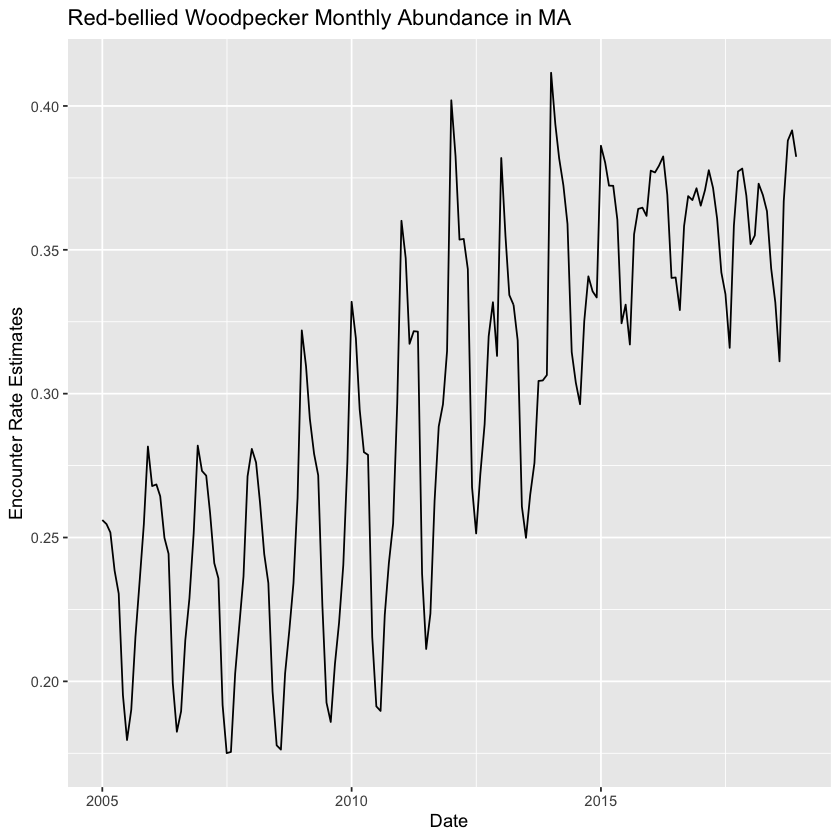

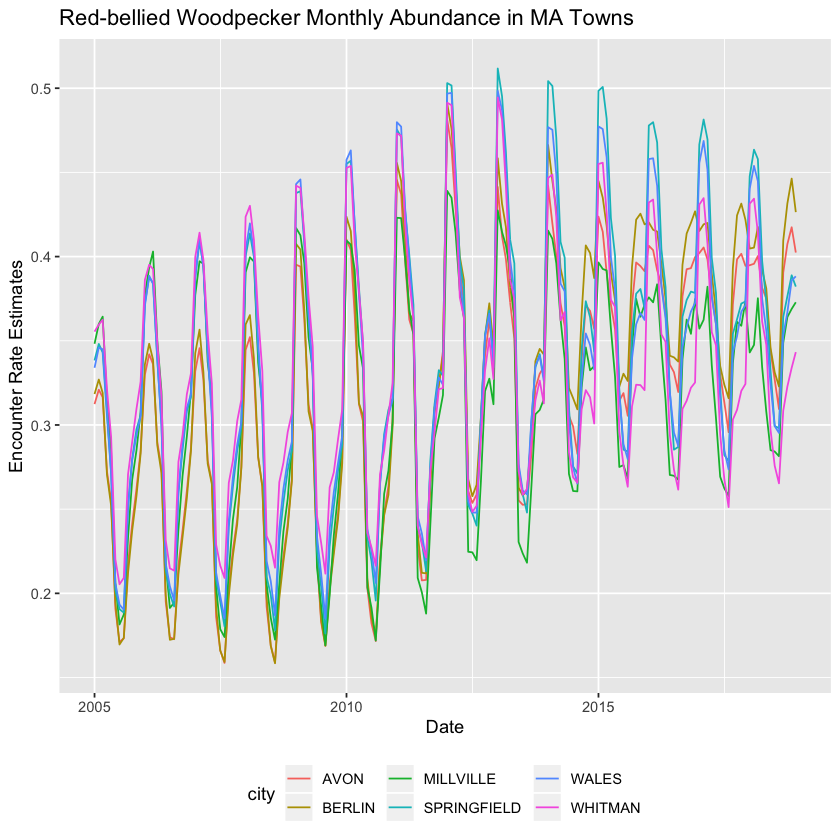

In [10]:

# Monthly encounter rate statewide from 2005-2018
ebird_occur_yrs <- ggplot(data=pred_er_MA, aes(x=date, y=encounter_rate, group=1)) +
  geom_line() +
  labs(x = "Date",
       y = "Encounter Rate Estimates",
       title= "Red-bellied Woodpecker Monthly Abundance in MA")
ebird_occur_yrs


# Monthly encounter rate by town from 2005-2018
ebird_occur_towns <- ggplot(data=filter(pred_er, city %in% c("AVON","BERLIN","MILLVILLE",
                                                          "WALES","WHITMAN","BOSTON", "SPRINGFIELD")),
                          aes(x=date, y=encounter_rate, group=city)) +
  geom_line(aes(color=city), show.legend = TRUE) +
  labs(x = "Date",
       y = "Encounter Rate Estimates",
       title= "Red-bellied Woodpecker Monthly Abundance in MA Towns") +
  theme(legend.position="bottom")
ebird_occur_towns